In [1]:
import torch
import matplotlib.pyplot as plt
from data import CropDataset  
import numpy as np
import rasterio
from CNN_Model import CropTypeClassifier
from shapely.geometry import Point, Polygon

import importlib



from data import CropDataset

In [3]:
def load_model(model_path, device):
    # Instancier ton modèle (adapte le constructeur à ta classe)
    model = CropTypeClassifier(num_classes=26)  
    # Charger les poids
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    
    # Envoyer le modèle sur le device (CPU ou GPU)
    model.to(device)
    
    return model

In [22]:
h5_path = '../data/Dataset.h5'
model_path = '../checkpoints/crop_model_epoch1.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = CropDataset(h5_path)
model = load_model(model_path, device)

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(pred, cmap='tab20')  # colormap adaptée pour classes catégorielles
plt.title('Mosaïque des prédictions dans la zone sélectionnée')
plt.colorbar()
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(gt, cmap='tab20')  # colormap adaptée pour classes catégorielles
plt.title('Mosaïque des prédictions dans la zone sélectionnée')
plt.colorbar()
plt.axis('off')
plt.show()

In [23]:
def create_spatial_mosaic_from_geo_coords(patches, geo_coords, patch_size, transform):
    pixel_coords = [rasterio.transform.rowcol(transform, lon, lat) for lon, lat in geo_coords]
    rows = [r for r, c in pixel_coords]
    cols = [c for r, c in pixel_coords]

    min_row, max_row = min(rows), max(rows)
    min_col, max_col = min(cols), max(cols)

    height = max_row - min_row + patch_size[0]
    width = max_col - min_col + patch_size[1]

    mosaic = np.full((height, width), -1, dtype=patches[0].dtype)

    for patch, (row, col) in zip(patches, pixel_coords):
        row_offset = row - min_row
        col_offset = col - min_col
        mosaic[row_offset:row_offset+patch_size[0], col_offset:col_offset+patch_size[1]] = patch

    return mosaic

In [24]:
    # Charger la transformée affine à partir d'un raster de référence (à adapter)
with rasterio.open('/Users/placiermoise/Documents/dsw_proj/remote sensing crop classification/data/Tif/zone1/labels_raster_masked.tif') as src:
    transform = src.transform



In [5]:
zone = str(dataset.get_zone(7000))
zone

'zone4'

In [25]:
target_zone = "zone3"  # ou le nom exact de ta zone cible
pred = []
gt = []
coords = []



for k in range(len(dataset)):
    zone = str(dataset.get_zone(k))
    if str(zone)!= target_zone:
        continue  # ignorer les autres zones

    x, y = dataset[k]
    coord = dataset.get_coord(k)

    x = x.unsqueeze(0).to(device)
    output = model(x)

    coords.append(coord)
    gt.append(y.squeeze(0).cpu().numpy())
    pred.append(output.argmax(dim=1).squeeze(0).cpu().numpy())



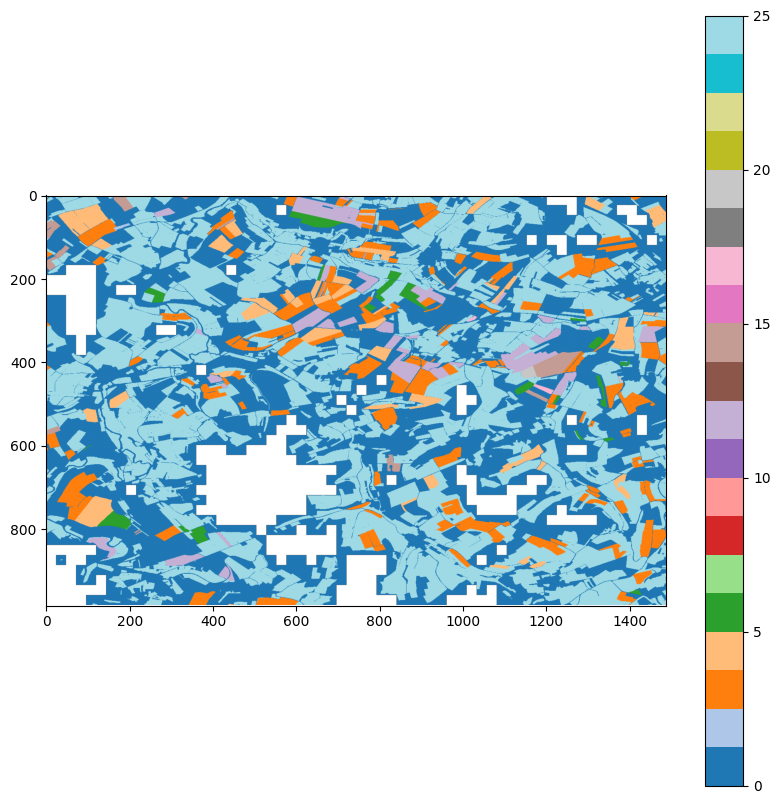

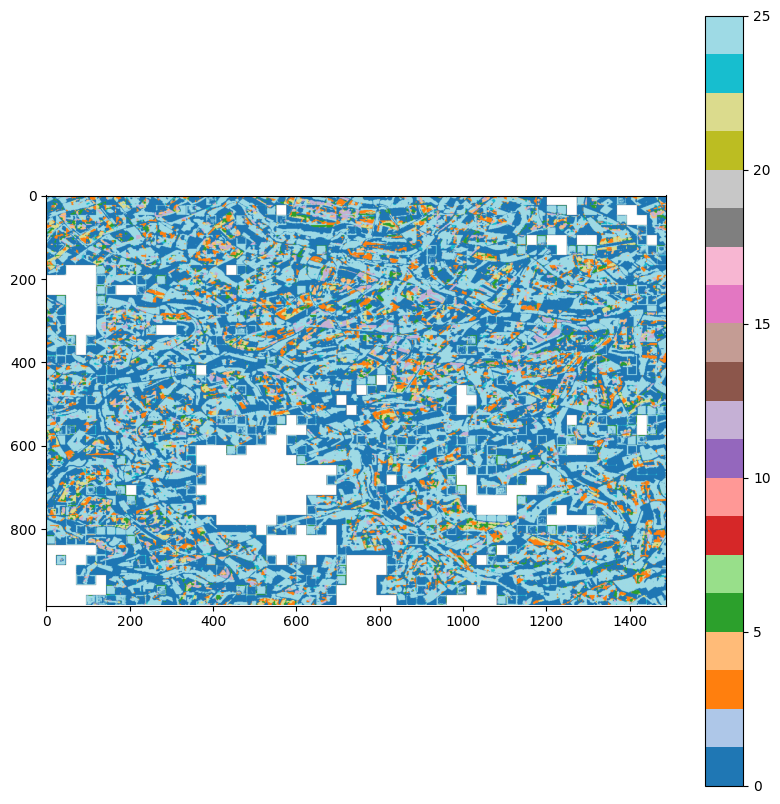

In [26]:
patch_size = dataset.Y.shape[1:]
mosaicpreds = create_spatial_mosaic_from_geo_coords(pred, coords, patch_size, transform)
mosaicgt = create_spatial_mosaic_from_geo_coords(gt, coords, patch_size, transform)

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Masquer les -1
cmap = 'tab20'
norm = mcolors.Normalize(vmin=0, vmax=gt[0].max())  # adapt to your values

masked_mosaic = np.ma.masked_where(mosaicgt == -1, mosaicgt)

mosaicpreds = np.ma.masked_where(mosaicpreds == -1, mosaicpreds)
plt.figure(figsize=(10, 10))
plt.imshow(masked_mosaic, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

plt.figure(figsize=(10, 10))
plt.imshow(mosaicpreds , cmap=cmap, norm=norm)
plt.colorbar()
plt.show()